## Tarea 3: Retropropagación, AutoEncoder
### Sergio Alberto De León Martínez

Primero importamos los datos, hacemos un split para datos de entrenamiento y test y finalmente normalizamos los valores de los pixeles en el intervalo [0, 1].

In [12]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [14]:
# Descargamos los datos
mnist = fetch_openml("mnist_784")
X, y = mnist.data, mnist.target.astype(int)

# Seleccion de solo imagenes de dígitos 0 y 1
X = X[(y == 0) | (y == 1)]
y = y[(y == 0) | (y == 1)]

# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar datos
X_train = X_train / 255.0
X_test  = X_test  / 255.0

# dimensiones de los conjuntos
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(11824, 784) (11824,)
(2956, 784) (2956,)


In [54]:
train_original, test_original,  = np.array(X_train).astype(np.float64), np.array(X_test).astype(np.float64)
print(train_original.shape, test_original.shape)

(11824, 784) (2956, 784)


A continuación voy a definir una clase a partir de la cuál van a heredar todas las capas de la red. Esta clase tiene una estructura muy sencilla, tiene como atributos el input y el output de la capa y metodos para propagar hacía adelante y hacía atrás.

In [33]:
class Layer:
  def __init__(self):
    self.input = None
    self.output = None

  def forward(self, input):
    # TO DO: return output
    pass

  def backward(self, output_gradient, learning_rate):
    # TO DO: update parameters and return input gradient
    pass

La capa densa hereda de la capa anterior, esta es la capa lineal, se inicializan los pesos y bias, en el metodo backward se calcula los gradientes y se actualizan los parametros y se regresa el gradiente que será utilizado en la siguiente capa del backpropagation.

In [34]:
class Dense(Layer):
  def __init__(self, input_size, output_size):
    self.weights = np.random.randn(output_size, input_size)
    self.bias = np.random.randn(output_size, 1)

  def forward(self, input):
    self.input = input
    return np.dot(self.weights, self.input) + self.bias

  def backward(self, output_gradient, learning_rate):
    weights_gradient = np.dot(output_gradient, self.input.T)
    self.weights -= learning_rate * weights_gradient
    self.bias -= learning_rate * output_gradient
    return np.dot(self.weights.T, output_gradient)


Se define una capa especial de activación y posteriormente se definen algunas funciones de activación que usaremos más adelante.

In [35]:
class Activation(Layer):
  def __init__(self, activation, activation_prime):
    self.activation = activation
    self.activation_prime = activation_prime

  def forward(self, input):
    self.input = input
    return self.activation(self.input)

  def backward(self, output_gradient, learning_rate):
    return np.multiply(output_gradient, self.activation_prime(self.input))


In [36]:
class Tanh(Activation):
  def __init__(self):
    tanh = lambda x: np.tanh(x)
    tanh_prime = lambda x: 1 - np.tanh(x) ** 2
    super().__init__(tanh, tanh_prime)

In [37]:
class Relu(Activation):
  def __init__(self):
    relu = lambda x: np.maximum(0, x)
    relu_prime = lambda x: np.where(x > 0, 1, 0)
    super().__init__(relu, relu_prime)

In [55]:
class Sigmoid(Activation):
  def __init__(self):
    sigmoid = lambda x: 1.0 / (1.0 + np.exp(-x))
    sigmoid_prime = lambda x: (1.0 / (1.0 + np.exp(-x))) * (1 - (1.0 / (1.0 + np.exp(-x))))
    super().__init__(sigmoid, sigmoid_prime)

Se define el error cuadrático medio como criterio y se define también su respectivo gradiente.

In [42]:
def mse(y_true, y_pred):
  return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
  return 2 * (y_pred - y_true)/np.size(y_true)

La red esta compuesta por una primera capa densa de dimensión 128, luego una capa de activación dada por tanh, luego una segunda capa densa de dimensión 16, nuevamente una capa de activación tanh, posterirmente regresamos al tamaño original con una capa densa y finalmente aplicamos una activación sigmoide. Cabe mencionar que opte por usar una capa de activación tanh en las capas intermedias ya que resulto tener una mejor estabilidad numérica. Primero utilice todas las observaciones para aplicar el paso de gradiente y luego en un segundo experimento use la versión estocástica.

In [64]:
# Configuración
input_dim = 28 * 28
epochs = 30
learning_rate = 0.01

#
network = [
    Dense(input_dim, 128),
    Tanh(),
    Dense(128, 16),
    Tanh(),
    Dense(16, 784),
    Sigmoid()
]

# train
for e in range(epochs):
  error = 0
  for original in train_original:
    original = original.reshape(784, 1)
    # forward
    reconstructed = original
    for layer in network:
      reconstructed = layer.forward(reconstructed)

    # error
    error += mse(original, reconstructed)

    # backward
    grad = mse_prime(original, reconstructed)
    for layer in reversed(network):
      grad = layer.backward(grad, learning_rate)

  error/= train_original.shape[0]
  print('%d/%d, error=%f' % (e + 1, epochs, error))

1/30, error=0.384209
2/30, error=0.375818
3/30, error=0.367746
4/30, error=0.359443
5/30, error=0.350573
6/30, error=0.341094
7/30, error=0.331265
8/30, error=0.321137
9/30, error=0.310617
10/30, error=0.299613
11/30, error=0.288405
12/30, error=0.277075
13/30, error=0.265547
14/30, error=0.253925
15/30, error=0.242287
16/30, error=0.231241
17/30, error=0.220917
18/30, error=0.211412
19/30, error=0.202814
20/30, error=0.195101
21/30, error=0.188138
22/30, error=0.181849
23/30, error=0.176114
24/30, error=0.170872
25/30, error=0.166095
26/30, error=0.161685
27/30, error=0.157531
28/30, error=0.153638
29/30, error=0.150060
30/30, error=0.146785


In [65]:
original_images = []
reconstructed_images = []
error = 0

for original in test_original:
  original = original.reshape(784, 1)
  # forward
  reconstructed = original
  for layer in network:
    reconstructed = layer.forward(reconstructed)

  original_images.append(original)
  reconstructed_images.append(reconstructed)

  # error
  error += mse(original, reconstructed)

error /= test_original.shape[0]
print("Error promedio", error)

Error promedio 0.1456644255102494


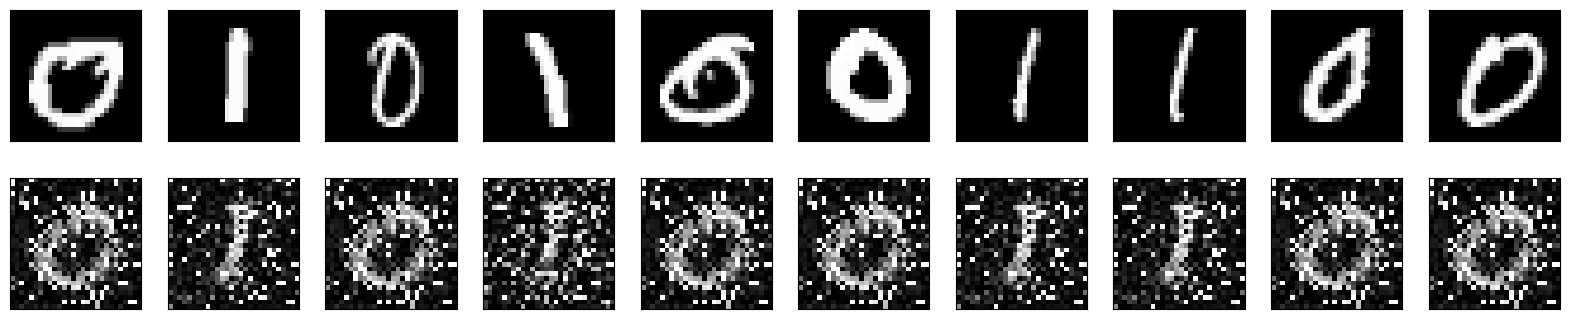

In [66]:
# Visualización de pares de imagenes originales y reconstruidas
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # Display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(original_images[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Display reconstructed
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(reconstructed_images[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Versión estocástica.

In [83]:
import random

# Configuración
input_dim = 28 * 28
epochs = 2000
learning_rate = 0.01
batch_size = 1000

#
network = [
    Dense(input_dim, 128),
    Tanh(),
    Dense(128, 16),
    Tanh(),
    Dense(16, 784),
    Sigmoid()
]

errores = []

# train
for e in range(epochs):
  error = 0
  sample = random.choices(train_original, k=batch_size)
  for original in sample:
    original = original.reshape(784, 1)
    # forward
    reconstructed = original
    for layer in network:
      reconstructed = layer.forward(reconstructed)

    # error
    error += mse(original, reconstructed)

    # backward
    grad = mse_prime(original, reconstructed)
    for layer in reversed(network):
      grad = layer.backward(grad, learning_rate)

  error/= batch_size
  errores.append(error)
  if (e + 1) % 50 == 0:
    print('%d/%d, error=%f' % (e + 1, epochs, error))

50/2000, error=0.341469
100/2000, error=0.287463
150/2000, error=0.229526
200/2000, error=0.184702
250/2000, error=0.157236
300/2000, error=0.137425
350/2000, error=0.124475
400/2000, error=0.116578
450/2000, error=0.109853
500/2000, error=0.104635
550/2000, error=0.101892
600/2000, error=0.098206
650/2000, error=0.095491
700/2000, error=0.094628
750/2000, error=0.090994
800/2000, error=0.090268
850/2000, error=0.089910
900/2000, error=0.088354
950/2000, error=0.087070
1000/2000, error=0.084080
1050/2000, error=0.083814
1100/2000, error=0.082729
1150/2000, error=0.080992
1200/2000, error=0.080607
1250/2000, error=0.081217
1300/2000, error=0.079224
1350/2000, error=0.077988
1400/2000, error=0.077714
1450/2000, error=0.078705
1500/2000, error=0.075522
1550/2000, error=0.076311
1600/2000, error=0.074727
1650/2000, error=0.073509
1700/2000, error=0.074955
1750/2000, error=0.075401
1800/2000, error=0.073940
1850/2000, error=0.074196
1900/2000, error=0.073874
1950/2000, error=0.074153
2000/2

In [84]:
original_images = []
reconstructed_images = []
error = 0

for original in test_original:
  original = original.reshape(784, 1)
  # forward
  reconstructed = original
  for layer in network:
    reconstructed = layer.forward(reconstructed)

  original_images.append(original)
  reconstructed_images.append(reconstructed)

  # error
  error += mse(original, reconstructed)

error /= test_original.shape[0]
print("Error promedio", error)

Error promedio 0.07368037595365522


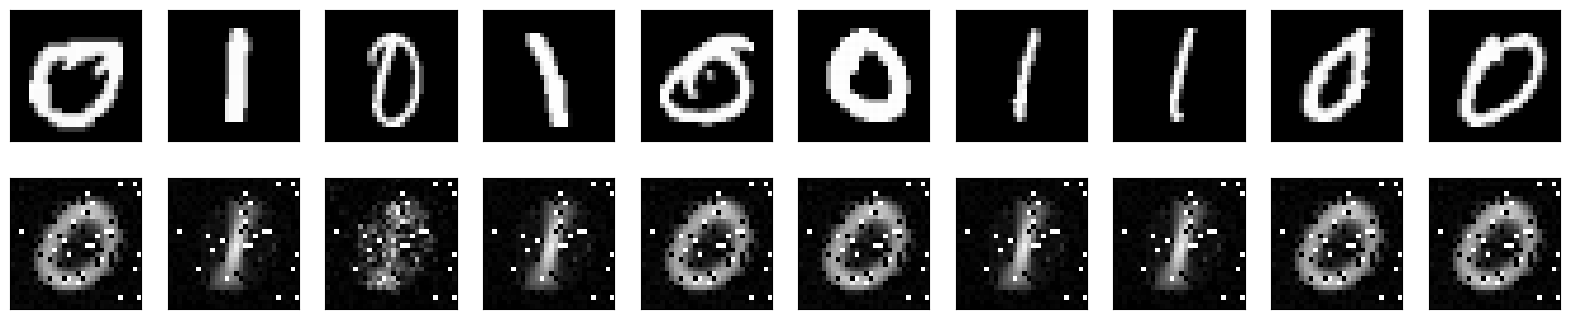

In [85]:
# Visualización de pares de imagenes originales y reconstruidas
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # Display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(original_images[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Display reconstructed
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(reconstructed_images[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()